<a href="https://colab.research.google.com/github/Sayed-Hossein-Hosseini/A_Journey_into_the_Depths_of_Neural_Networks/blob/master/Entering_the_World_of_Deep_Neural_Networks_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entering the World of Deep Neural Networks CNN**

## **Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## **GPU**

In [2]:
#0. Check GPU availability and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Hyperparameters**

In [3]:
#1. Hyperparameters
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.05

## **CIFAR-10 Data Preparation**

### **Preprocessing**

In [4]:
# Transformations: Tensor Conversion and Normalization
# Mean and Standard Deviation Values ​​for CIFAR-10 (Standard)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # مقادیر دقیق‌تر
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # ساده‌تر، برای نرمال‌سازی به بازه [-1, 1]
])

### **Download and Load the Training Dataset**

In [5]:
# Download and load training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


### **Download and Load the Test Dataset**

In [7]:
# Download and load the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### **CIFAR-10 Classes**

In [8]:
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### **Display Images**

<ipython-input-15-d47584482e73>:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img = img * std[:, None, None] + mean[:, None, None]


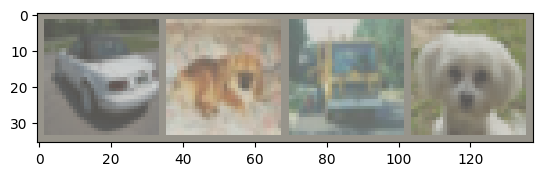

car   dog   truck dog  


In [15]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize if normalized to [-1,1]
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img * std[:, None, None] + mean[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show some random educational images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## **CNN Model Definition**

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Input: 3x32x32 (channels, height, width)

        # First convolutional layer: 32 filters, kernel size 3x3, ReLU activation
        # Output with padding=1: 32x32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # First Max Pooling layer: pool size 2x2
        # Output: 32x16x16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer: 64 filters, kernel size 3x3, ReLU activation
        # Output with padding=1: 64x16x16
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # Second Max Pooling layer: pool size 2x2
        # Output: 64x8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten layer
        # Flattened input dimensions: 64 * 8 * 8 = 4096
        self.flatten = nn.Flatten()

        # First Fully Connected layer: 128 neurons, ReLU activation
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()

        # Second Fully Connected layer (output layer): 10 neurons, Softmax activation
        # Note: nn.CrossEntropyLoss combines LogSoftmax and NLLLoss internally.
        # Therefore, if you use nn.CrossEntropyLoss, you don't need a separate Softmax layer.
        # But if you want the output to be probabilities (e.g., for inference) or use NLLLoss, LogSoftmax is more suitable.
        # If specifically Softmax is required, it can be applied in the forward method.
        self.fc2 = nn.Linear(128, num_classes)
        # self.softmax = nn.Softmax(dim=1)  # or nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)  # or x = x.view(-1, 64 * 8 * 8)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        # If we want the output to be probabilities directly:
        # x = self.softmax(x)  # Typically used during inference, not during training with CrossEntropyLoss
        # Or if using NLLLoss:
        # x = F.log_softmax(x, dim=1)
        return x

model = CNN(num_classes=len(classes)).to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
